Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Load data

In [6]:
df = pd.read_csv("Credit.csv")
df = df.drop('Unnamed: 0', axis=1)
df['inc_gt_50'] = (df['Income'] > 50).astype(int)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     400 non-null    float64
 1   Limit      400 non-null    int64  
 2   Rating     400 non-null    int64  
 3   Cards      400 non-null    int64  
 4   Age        400 non-null    int64  
 5   Education  400 non-null    int64  
 6   Gender     400 non-null    object 
 7   Student    400 non-null    object 
 8   Married    400 non-null    object 
 9   Ethnicity  400 non-null    object 
 10  Balance    400 non-null    int64  
 11  inc_gt_50  400 non-null    int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 37.6+ KB
None


,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,inc_gt_50
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,1
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964,1
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331,1


Decision tree classifier

In [7]:
def decisionTree(df, formula, seed, max_depth=3):
    np.random.seed(seed)
    mask = np.random.rand(len(df)) < 0.8
    train_set = df[mask]
    valid_set = df[~mask]
    
    train_y, train_x = dmatrices(formula, data=train_set, return_type="dataframe")
    valid_y, valid_x = dmatrices(formula, data=valid_set, return_type="dataframe")
    
    model = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    result = model.fit(train_x, train_y)
    
    train_acc = accuracy_score(train_y, model.predict(train_x))
    val_acc = accuracy_score(valid_y, model.predict(valid_x))
    val_maj_proportion = max(valid_set[formula.split()[0]].value_counts(normalize=True))

    return train_acc, val_acc, val_maj_proportion

KNN classifier

In [8]:
def knn(df, formula, seed, n_neighbors=5):
    np.random.seed(seed)
    mask = np.random.rand(len(df)) < 0.8
    train_set = df[mask]
    valid_set = df[~mask]
    
    train_y, train_x = dmatrices(formula, data=train_set, return_type="dataframe")
    valid_y, valid_x = dmatrices(formula, data=valid_set, return_type="dataframe")
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    train_y = np.array(train_y).reshape(len(train_y,))
    result = model.fit(train_x, train_y)
    
    train_acc = accuracy_score(train_y, model.predict(train_x))
    val_acc = accuracy_score(valid_y, model.predict(valid_x))
    val_maj_proportion = max(valid_set[formula.split()[0]].value_counts(normalize=True))

    return train_acc, val_acc, val_maj_proportion

Predict income greater than 50

In [9]:
df_numeric = pd.get_dummies(df, columns=["Gender", "Student", "Married", "Ethnicity"], drop_first=True)
correlation_matrix = df_numeric.corr()
print("inc_gt_50:")
print(correlation_matrix["inc_gt_50"].drop("inc_gt_50").sort_values(ascending=False))

inc_gt_50:
Income                 0.797502
Limit                  0.634231
Rating                 0.628991
Balance                0.349252
Age                    0.166677
Married_Yes            0.022746
Ethnicity_Caucasian    0.014163
Gender_Female          0.008979
Student_Yes           -0.007207
Education             -0.023899
Cards                 -0.026562
Ethnicity_Asian       -0.032493
Name: inc_gt_50, dtype: float64


Decision Tree

In [10]:
formulas = [
    "inc_gt_50 ~ Limit",
    "inc_gt_50 ~ Rating",
    "inc_gt_50 ~ Cards",
    "inc_gt_50 ~ Age",
    "inc_gt_50 ~ Education",
    "inc_gt_50 ~ Gender",
    "inc_gt_50 ~ Student",
    "inc_gt_50 ~ Married",
    "inc_gt_50 ~ Ethnicity",
    "inc_gt_50 ~ Balance",
]
better_formulas = [
    "inc_gt_50 ~ Limit + Rating",
    "inc_gt_50 ~ Limit + Balance",
    "inc_gt_50 ~ Rating + Balance",
    "inc_gt_50 ~ Limit + Rating + Balance",
    "inc_gt_50 ~ Limit + Rating + Balance + Age",
    "inc_gt_50 ~ Limit + Rating + Balance + Age",
    "inc_gt_50 ~ Limit + Rating + Balance + Age + Education + Gender + Student + Married + Ethnicity + Balance",
]

seed = np.random.randint(2**32)
train_acc, val_acc, val_maj_proportion = decisionTree(df, "inc_gt_50 ~ Limit", seed)
print(f"\033[91mMajority class proportion of validation set: {val_maj_proportion:.4f}\033[0m")
for f in formulas:
    print(f"\033[94m{f}:\033[0m")
    train_acc, val_acc, _ = decisionTree(df, f, seed, 3)
    print(f"\tValidation accuracy: {val_acc:.4f}")
print("--------------------------------------")
for f in better_formulas:
    print(f"\033[94m{f}:\033[0m")
    train_acc, val_acc, _ = decisionTree(df, f, seed, 3)
    print(f"\tTraining accuracy: {train_acc:.4f}")
    print(f"\tValidation accuracy: {val_acc:.4f}")

Majority class proportion of validation set: 0.6860
inc_gt_50 ~ Limit:
	Validation accuracy: 0.7907
inc_gt_50 ~ Rating:
	Validation accuracy: 0.8140
inc_gt_50 ~ Cards:
	Validation accuracy: 0.6860
inc_gt_50 ~ Age:
	Validation accuracy: 0.6977
inc_gt_50 ~ Education:
	Validation accuracy: 0.6860
inc_gt_50 ~ Gender:
	Validation accuracy: 0.6860
inc_gt_50 ~ Student:
	Validation accuracy: 0.6860
inc_gt_50 ~ Married:
	Validation accuracy: 0.6860
inc_gt_50 ~ Ethnicity:
	Validation accuracy: 0.6860
inc_gt_50 ~ Balance:
	Validation accuracy: 0.7558
--------------------------------------
inc_gt_50 ~ Limit + Rating:
	Training accuracy: 0.8694
	Validation accuracy: 0.7907
inc_gt_50 ~ Limit + Balance:
	Training accuracy: 0.9108
	Validation accuracy: 0.8488
inc_gt_50 ~ Rating + Balance:


	Training accuracy: 0.9076
	Validation accuracy: 0.8837
inc_gt_50 ~ Limit + Rating + Balance:
	Training accuracy: 0.9108
	Validation accuracy: 0.8488
inc_gt_50 ~ Limit + Rating + Balance + Age:
	Training accuracy: 0.9108
	Validation accuracy: 0.8372
inc_gt_50 ~ Limit + Rating + Balance + Age:
	Training accuracy: 0.9108
	Validation accuracy: 0.8372
inc_gt_50 ~ Limit + Rating + Balance + Age + Education + Gender + Student + Married + Ethnicity + Balance:
	Training accuracy: 0.9108
	Validation accuracy: 0.8372


KNN

In [11]:
formulas = [
    "inc_gt_50 ~ Limit",
    "inc_gt_50 ~ Rating",
    "inc_gt_50 ~ Cards",
    "inc_gt_50 ~ Age",
    "inc_gt_50 ~ Education",
    "inc_gt_50 ~ Gender",
    "inc_gt_50 ~ Student",
    "inc_gt_50 ~ Married",
    "inc_gt_50 ~ Ethnicity",
    "inc_gt_50 ~ Balance",
]
better_formulas = [
    "inc_gt_50 ~ Limit + Rating",
    "inc_gt_50 ~ Limit + Balance",
    "inc_gt_50 ~ Rating + Balance",
    "inc_gt_50 ~ Limit + Rating + Balance",
    "inc_gt_50 ~ Limit + Rating + Balance + Age",
    "inc_gt_50 ~ Limit + Rating + Balance + Age",
    "inc_gt_50 ~ Limit + Rating + Balance + Age + Education + Gender + Student + Married + Ethnicity + Balance",
]

seed = np.random.randint(2**32)
train_acc, val_acc, val_maj_proportion = knn(df, "inc_gt_50 ~ Limit", seed)
print(f"\033[91mMajority class proportion of validation set: {val_maj_proportion:.4f}\033[0m")
for f in formulas:
    print(f"\033[94m{f}:\033[0m")
    train_acc, val_acc, _ = knn(df, f, seed, 5)
    print(f"\tValidation accuracy: {val_acc:.4f}")
print("--------------------------------------")
for f in better_formulas:
    print(f"\033[94m{f}:\033[0m")
    train_acc, val_acc, _ = knn(df, f, seed, 5)
    print(f"\tTraining accuracy: {train_acc:.4f}")
    print(f"\tValidation accuracy: {val_acc:.4f}")

Majority class proportion of validation set: 0.6901
inc_gt_50 ~ Limit:
	Validation accuracy: 0.8451
inc_gt_50 ~ Rating:


	Validation accuracy: 0.8732
inc_gt_50 ~ Cards:
	Validation accuracy: 0.6479
inc_gt_50 ~ Age:
	Validation accuracy: 0.6901
inc_gt_50 ~ Education:
	Validation accuracy: 0.6056
inc_gt_50 ~ Gender:
	Validation accuracy: 0.3099
inc_gt_50 ~ Student:
	Validation accuracy: 0.3662
inc_gt_50 ~ Married:
	Validation accuracy: 0.3099
inc_gt_50 ~ Ethnicity:
	Validation accuracy: 0.5634
inc_gt_50 ~ Balance:
	Validation accuracy: 0.7465
--------------------------------------
inc_gt_50 ~ Limit + Rating:
	Training accuracy: 0.8602
	Validation accuracy: 0.8592
inc_gt_50 ~ Limit + Balance:
	Training accuracy: 0.9392
	Validation accuracy: 0.9859
inc_gt_50 ~ Rating + Balance:
	Training accuracy: 0.9362
	Validation accuracy: 0.9577
inc_gt_50 ~ Limit + Rating + Balance:
	Training accuracy: 0.9392
	Validation accuracy: 0.9859
inc_gt_50 ~ Limit + Rating + Balance + Age:
	Training accuracy: 0.9362
	Validation accuracy: 0.9859
inc_gt_50 ~ Limit + Rating + Balance + Age:
	Training accuracy: 0.9362
	Validation acc

Cross validation and grid search

In [53]:
model_formula = "inc_gt_50 ~ Limit + Rating + Balance"
y, x = dmatrices(model_formula, data=df, return_type='dataframe')
Y = y.values.ravel()
X = x.values

In [59]:
from sklearn.model_selection import GridSearchCV

params_opt = {'max_depth':range(1, 50, 1)}

gridSearchCV = GridSearchCV(
    estimator = DecisionTreeClassifier(), 
    param_grid = params_opt,
    cv=10)
gridSearchCV.fit(X,Y)

results = pd.DataFrame(gridSearchCV.cv_results_)

# Sort the results by the mean test score in descending order
sorted_results = results.sort_values(by='mean_test_score', ascending=False)

# Print the top 5 parameter sets
print("Top 10 parameter sets:")
print(sorted_results.loc[:, ['params', 'mean_test_score']].head(10))

Top 10 parameter sets:
               params  mean_test_score
6    {'max_depth': 7}           0.9250
28  {'max_depth': 29}           0.9225
29  {'max_depth': 30}           0.9225
21  {'max_depth': 22}           0.9225
16  {'max_depth': 17}           0.9225
43  {'max_depth': 44}           0.9225
42  {'max_depth': 43}           0.9225
44  {'max_depth': 45}           0.9225
19  {'max_depth': 20}           0.9225
8    {'max_depth': 9}           0.9225


In [62]:
from sklearn.model_selection import GridSearchCV

params_opt = {'n_neighbors':range(1, 30, 1)}

gridSearchCV = GridSearchCV(
    estimator = KNeighborsClassifier(), 
    param_grid = params_opt,
    cv=10)
gridSearchCV.fit(X,Y)

results = pd.DataFrame(gridSearchCV.cv_results_)

# Sort the results by the mean test score in descending order
sorted_results = results.sort_values(by='mean_test_score', ascending=False)

# Print the top 5 parameter sets
print("Top 10 parameter sets:")
print(sorted_results.loc[:, ['params', 'mean_test_score']].head(10))

Top 10 parameter sets:
                 params  mean_test_score
4    {'n_neighbors': 5}           0.9400
1    {'n_neighbors': 2}           0.9375
0    {'n_neighbors': 1}           0.9350
2    {'n_neighbors': 3}           0.9325
3    {'n_neighbors': 4}           0.9275
6    {'n_neighbors': 7}           0.9275
7    {'n_neighbors': 8}           0.9275
8    {'n_neighbors': 9}           0.9275
5    {'n_neighbors': 6}           0.9225
12  {'n_neighbors': 13}           0.9150


LRE :
	mean: 0.9525,	std: 0.0146
KNN1:
	mean: 0.9400,	std: 0.0122
KNN2:
	mean: 0.9375,	std: 0.0112
KNN5:
	mean: 0.9325,	std: 0.0150
DTC7:
	mean: 0.9150,	std: 0.0200
DTC17:
	mean: 0.9050,	std: 0.0269
DTC29:
	mean: 0.9050,	std: 0.0187


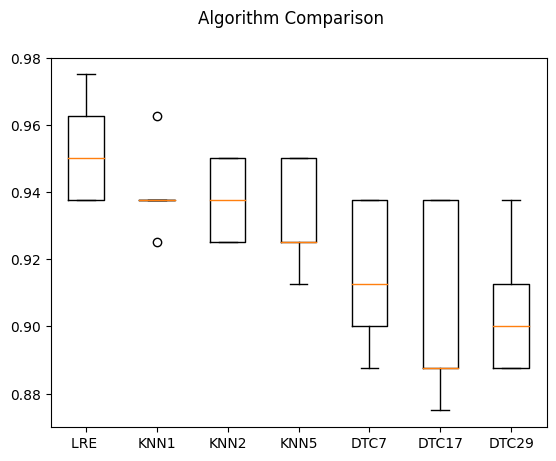

In [63]:
models = []
models.append(('LRE ', LogisticRegression()))
models.append(('KNN1', KNeighborsClassifier(n_neighbors=1)))
models.append(('KNN2', KNeighborsClassifier(n_neighbors=2)))
models.append(('KNN5', KNeighborsClassifier(n_neighbors=5)))
models.append(('DTC7', DecisionTreeClassifier(max_depth=7)))
models.append(('DTC17', DecisionTreeClassifier(max_depth=17)))
models.append(('DTC29', DecisionTreeClassifier(max_depth=29)))

results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=5)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    # msg = "%s:     mean: %f       std: %f" % (name, cv_results.mean(), cv_results.std())
    # print(msg)
    print(f"\033[94m{name}\033[0m:\n\tmean: {cv_results.mean():.4f},\tstd: {cv_results.std():.4f}")

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()